In [15]:
import pandas as pd
import numpy as np
import pylab as pl
import PIL
from PIL import Image
import os
import base64
from StringIO import StringIO

In [16]:
from sklearn.decomposition import RandomizedPCA
from sklearn.neighbors import KNeighborsClassifier

In [17]:
%matplotlib inline


In [70]:
#setup a standard image size; this will distort some images but will get everything into the same shape
STANDARD_SIZE = (300, 167)
def img_to_matrix(filename, verbose=False):
    """
    takes a filename and turns it into a numpy array of RGB pixels
    """
    img = PIL.Image.open(filename)
    if verbose==True:
        print "changing size from %s to %s" % (str(img.size), str(STANDARD_SIZE))
    img = img.resize(STANDARD_SIZE)
    img = list(img.getdata())
    img = map(list, img)
    img = np.array(img)
    return img

def flatten_image(img):
    """
    takes in an (m, n) numpy array and flattens it 
    into an array of shape (1, m * n)
    """
    s = img.shape[0] * img.shape[1]
    img_wide = img.reshape(1, s)
    return img_wide[0]

In [71]:
img_dir = 'images/'
images = [img_dir+ f for f in os.listdir(img_dir)]
labels = ["check" if "check" in f.split('/')[-1] else "drivers_license" for f in images]

data = []
for image in images:
    img = img_to_matrix(image)
    img = flatten_image(img)
    data.append(img)

data = np.array(data)
data

array([[  1,   7,   5, ...,  16,  22,  22],
       [132, 130,  73, ..., 178, 153,  96],
       [241, 215, 190, ..., 252, 236, 202],
       ..., 
       [ 54,  79,  39, ...,  82,  83,  67],
       [101, 102,  97, ...,  91,  92,  87],
       [  8,   7,   5, ...,   1,   6,   2]])

In [72]:
is_train = np.random.uniform(0, 1, len(data)) <= 0.7
y = np.where(np.array(labels)=="check", 1, 0)

train_x, train_y = data[is_train], y[is_train]
test_x, test_y = data[is_train==False], y[is_train==False]

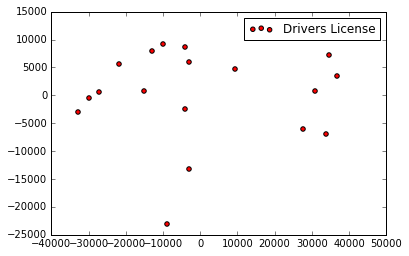

In [73]:
pca = RandomizedPCA(n_components=2)
X = pca.fit_transform(data)
df = pd.DataFrame({"x": X[:, 0], "y": X[:, 1], "label":np.where(y==1, "Check", "Drivers License")})
colors = ["red", "yellow"]
for label, color in zip(df['label'].unique(), colors):
    mask = df['label']==label
    pl.scatter(df[mask]['x'], df[mask]['y'], c=color, label=label)
pl.legend()

In [74]:
pca = RandomizedPCA(n_components=5)
train_x = pca.fit_transform(train_x)
test_x = pca.transform(test_x)

In [75]:
train_x[:5]


array([[-35079.63547801,  -4148.66424244,  -9984.57033345,  -4856.8936629 ,
          1298.16614411],
       [ 32712.36614114,   4720.04047652,  -3747.30050214,   1719.22775003,
         -3424.66846222],
       [-11785.81585342, -24935.5323578 ,  11010.35162096,   2199.17833336,
          1776.69676179],
       [-24191.21253481,   5528.1643389 ,  -3230.3042622 ,  -2892.87630752,
         -5074.50718959],
       [-29631.3596673 ,   -863.67851633,  -9005.84658381,   6691.10507498,
          -965.90206331]])

In [76]:
knn = KNeighborsClassifier()
knn.fit(train_x, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [77]:
pd.crosstab(test_y, knn.predict(test_x), rownames=["Actual"], colnames=["Predicted"])


Predicted,0
Actual,
0,6


In [78]:
STANDARD_SIZE

(300, 167)

In [79]:
def string_to_img(image_string):
    print "called string_to_image"
    #we need to decode the image from base64
    image_string = base64.decodestring(image_string)
    #since we're seing this as a JSON string, we use StringIO so it acts like a file
    img = StringIO(image_string)
    img = PIL.Image.open(img)
    img = img.resize(STANDARD_SIZE)
    img = list(img.getdata())
    img = map(list, img)
    img = np.array(img)
    s = img.shape[0] * img.shape[1]
    img_wide = img.reshape(1, s)
    return pca.transform(img_wide[0])

In [80]:
def classify_image(data):
    print "called classify_image"
    preds = knn.predict(data)
    preds = np.where(preds==1, "check", "drivers_license")
    pred = preds[0]
    return {"image_label": pred}

In [81]:
def execute(data):
    print "called execute"
    img_string = data.get("image_as_base64_string", None)
    if img_string is None:
        return {"status": "error", "message": "data was None", "input_data": data}
    else:
        img = string_to_img(img_string)
        pred = classify_image(img)
        return pred